<a href="https://colab.research.google.com/github/anupojuharshita/Anndata/blob/main/HSTM%20Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving combined_dataset (1).zip to combined_dataset (1).zip


In [ ]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K


In [ ]:
import zipfile  # ✅ Fixes the error

zip_path = "/content/combined_dataset (1).zip"
extract_path = "/mnt/data/combined_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = 128
DATASET_PATH = "/mnt/data/combined_dataset"

# Step 1.1: Load and sort image paths
image_paths = sorted([os.path.join(DATASET_PATH, fname) for fname in os.listdir(DATASET_PATH) if fname.endswith('.jpg')])

# Step 1.2: Split into input-target pairs (even-indexed = input, odd-indexed = target)
inputs = []
targets = []

for i in range(0, len(image_paths) - 1, 2):
    inp = cv2.imread(image_paths[i])
    tar = cv2.imread(image_paths[i + 1])
    inp = cv2.resize(inp, (IMAGE_SIZE, IMAGE_SIZE))
    tar = cv2.resize(tar, (IMAGE_SIZE, IMAGE_SIZE))
    inputs.append(inp / 255.0)
    targets.append(tar / 255.0)

inputs = np.array(inputs, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

# Step 1.3: Train-test split
x_train, x_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras import layers, models

def multi_scale_curve_encoder(x):
    x1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x2 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(x)
    x3 = layers.Conv2D(32, (7, 7), padding='same', activation='relu')(x)
    x = layers.Concatenate()([x1, x2, x3])
    return x

def temporal_attention_block(x):
    B, H, W, C = x.shape
    x_reshaped = layers.Reshape((H * W, C))(x)
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x_reshaped, x_reshaped)
    x = layers.Add()([x_reshaped, attention])
    x = layers.LayerNormalization()(x)
    return layers.Reshape((H, W, C))(x)

def build_hsta_mce(input_shape=(128, 128, 3)):
    inp = layers.Input(shape=input_shape)

    # Encoder (CNN + Curve Encoding)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = multi_scale_curve_encoder(x)
    x = layers.MaxPooling2D()(x)

    # Attention
    x = temporal_attention_block(x)

    # Decoder
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    out = layers.Conv2D(3, 1, activation='sigmoid')(x)

    return models.Model(inputs=inp, outputs=out)


In [ ]:
def pixel_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)
    return correct / total



🔁 Training for 10 epochs...
✅ Epochs = 10 → Pixel Accuracy = 93.73%

🔁 Training for 20 epochs...
✅ Epochs = 20 → Pixel Accuracy = 93.81%

🔁 Training for 30 epochs...
✅ Epochs = 30 → Pixel Accuracy = 94.99%

🔁 Training for 40 epochs...
✅ Epochs = 40 → Pixel Accuracy = 95.23%

🔁 Training for 50 epochs...
✅ Epochs = 50 → Pixel Accuracy = 95.62%


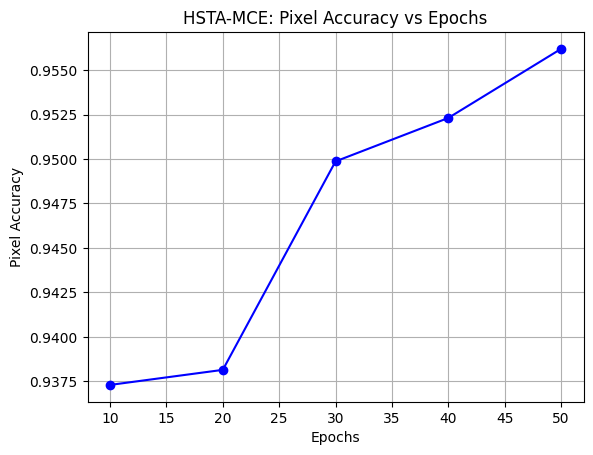

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


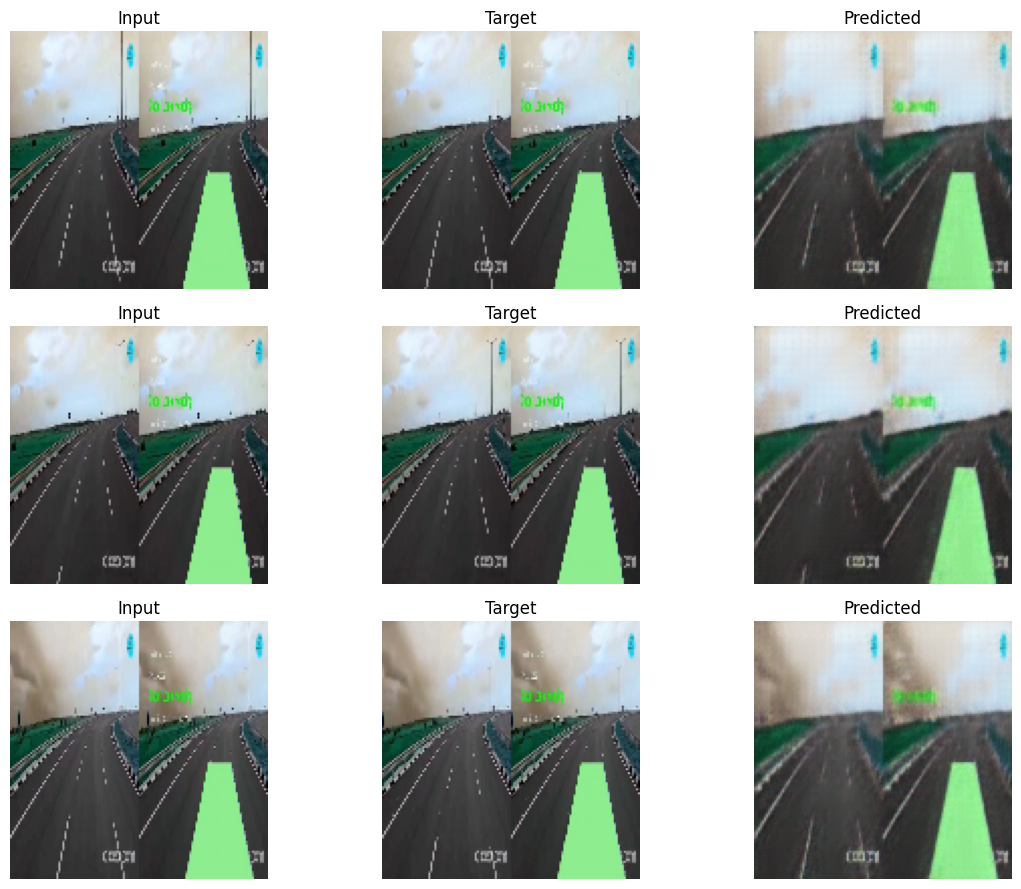

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import zipfile  # ✅ Fixes the error

zip_path = "/content/combined_dataset (1).zip"
extract_path = "/mnt/data/combined_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# =========================
# 🔹 Step 1: Load and Preprocess Dataset
# =========================
IMAGE_SIZE = 128
DATASET_PATH = "/mnt/data/combined_dataset"

# Load and sort image paths
image_paths = sorted([os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith(".jpg")])

# Separate into input-target pairs (even-indexed = input, odd-indexed = target)
inputs = []
targets = []
for i in range(0, len(image_paths) - 1, 2):
    inp = cv2.imread(image_paths[i])
    tar = cv2.imread(image_paths[i + 1])
    inp = cv2.resize(inp, (IMAGE_SIZE, IMAGE_SIZE))
    tar = cv2.resize(tar, (IMAGE_SIZE, IMAGE_SIZE))
    inputs.append(inp / 255.0)
    targets.append(tar / 255.0)

inputs = np.array(inputs, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# =========================
# 🔹 Step 2: Define Model (HSTA-MCE)
# =========================
from tensorflow.keras import layers, models

def multi_scale_curve_encoder(x):
    x1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x2 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(x)
    x3 = layers.Conv2D(32, (7, 7), padding='same', activation='relu')(x)
    return layers.Concatenate()([x1, x2, x3])

def temporal_attention_block(x):
    H, W, C = x.shape[1], x.shape[2], x.shape[3]
    x_reshaped = layers.Reshape((H * W, C))(x)
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x_reshaped, x_reshaped)
    x = layers.Add()([x_reshaped, attention])
    x = layers.LayerNormalization()(x)
    return layers.Reshape((H, W, C))(x)

def build_hsta_mce(input_shape=(128, 128, 3)):
    inp = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = multi_scale_curve_encoder(x)
    x = layers.MaxPooling2D()(x)

    # Attention
    x = temporal_attention_block(x)

    # Decoder
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    out = layers.Conv2D(3, 1, activation='sigmoid')(x)

    return models.Model(inputs=inp, outputs=out)

# =========================
# 🔹 Step 3: Custom Pixel Accuracy Metric (Fixed with Threshold)
# =========================
def pixel_accuracy(y_true, y_pred):
    y_pred_bin = tf.where(y_pred > 0.5, 1.0, 0.0)
    y_true_bin = tf.where(y_true > 0.5, 1.0, 0.0)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true_bin, y_pred_bin), tf.float32))
    total = tf.cast(tf.size(y_true_bin, out_type=tf.int32), tf.float32)
    return correct / total

# =========================
# 🔹 Step 4: Training with Multiple Epoch Values
# =========================
epoch_values = [10, 20, 30, 40, 50]
accuracy_results = []

for epochs in epoch_values:
    model = build_hsta_mce()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=[pixel_accuracy])

    print(f"\n🔁 Training for {epochs} epochs...")
    model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=epochs, batch_size=16, verbose=0)

    acc = model.evaluate(x_val, y_val, verbose=0)[1]
    accuracy_results.append((epochs, acc))
    print(f"✅ Epochs = {epochs} → Pixel Accuracy = {acc:.2%}")

# =========================
# 🔹 Step 5: Plot Accuracy vs Epochs
# =========================
epochs_list, acc_list = zip(*accuracy_results)
plt.plot(epochs_list, acc_list, marker='o', color='blue')
plt.title("HSTA-MCE: Pixel Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Pixel Accuracy")
plt.grid(True)
plt.show()

# =========================
# 🔹 Step 6: Show Predictions
# =========================
predictions = model.predict(x_val[:3])

plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 3, 3 * i + 1)
    plt.imshow(x_val[i])
    plt.title("Input")
    plt.axis("off")

    plt.subplot(3, 3, 3 * i + 2)
    plt.imshow(y_val[i])
    plt.title("Target")
    plt.axis("off")

    plt.subplot(3, 3, 3 * i + 3)
    plt.imshow(predictions[i])
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


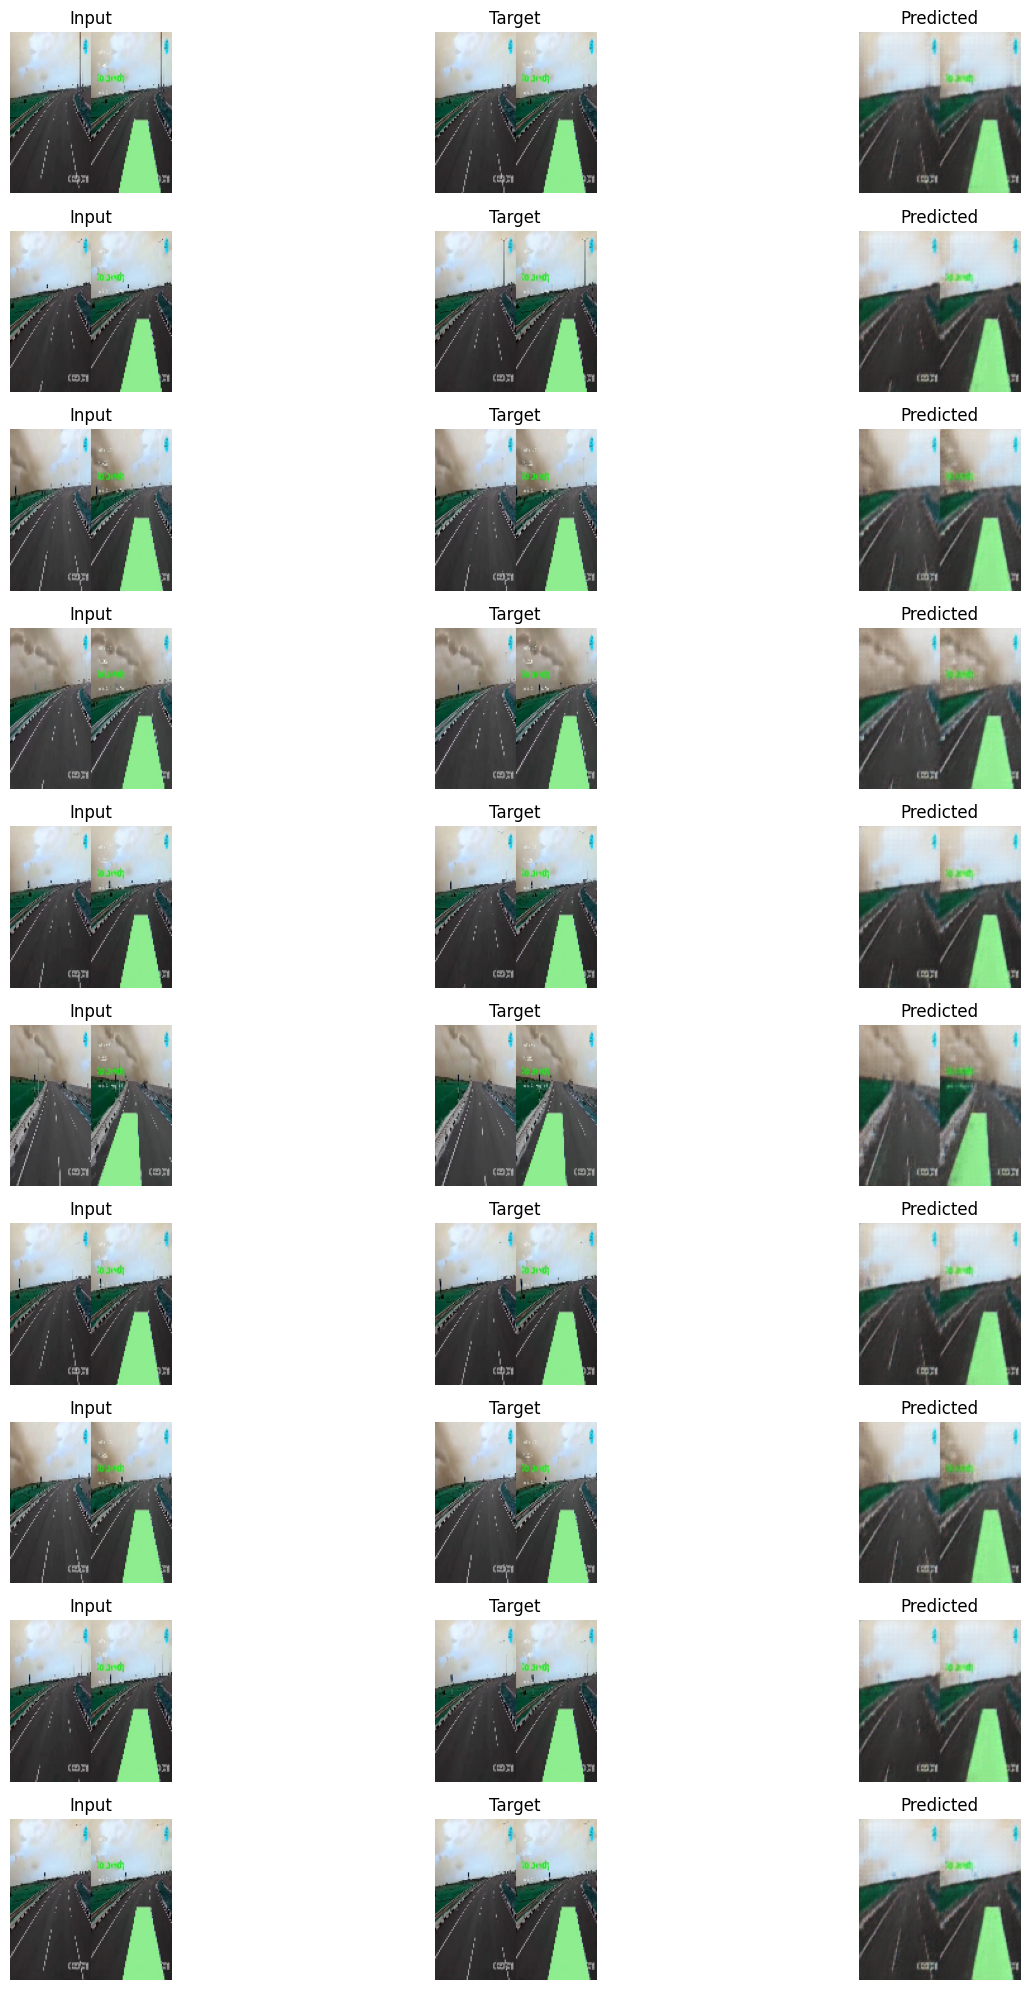

In [ ]:
import matplotlib.pyplot as plt

# Predict on the first 10 validation images
num_samples = 10
predictions = model.predict(x_val[:num_samples])

# Plot input, target, and predicted output for each sample
plt.figure(figsize=(15, num_samples * 2))

for i in range(num_samples):
    # Input
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(x_val[i])
    plt.title("Input")
    plt.axis("off")

    # Target
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(y_val[i])
    plt.title("Target")
    plt.axis("off")

    # Prediction
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(predictions[i])
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


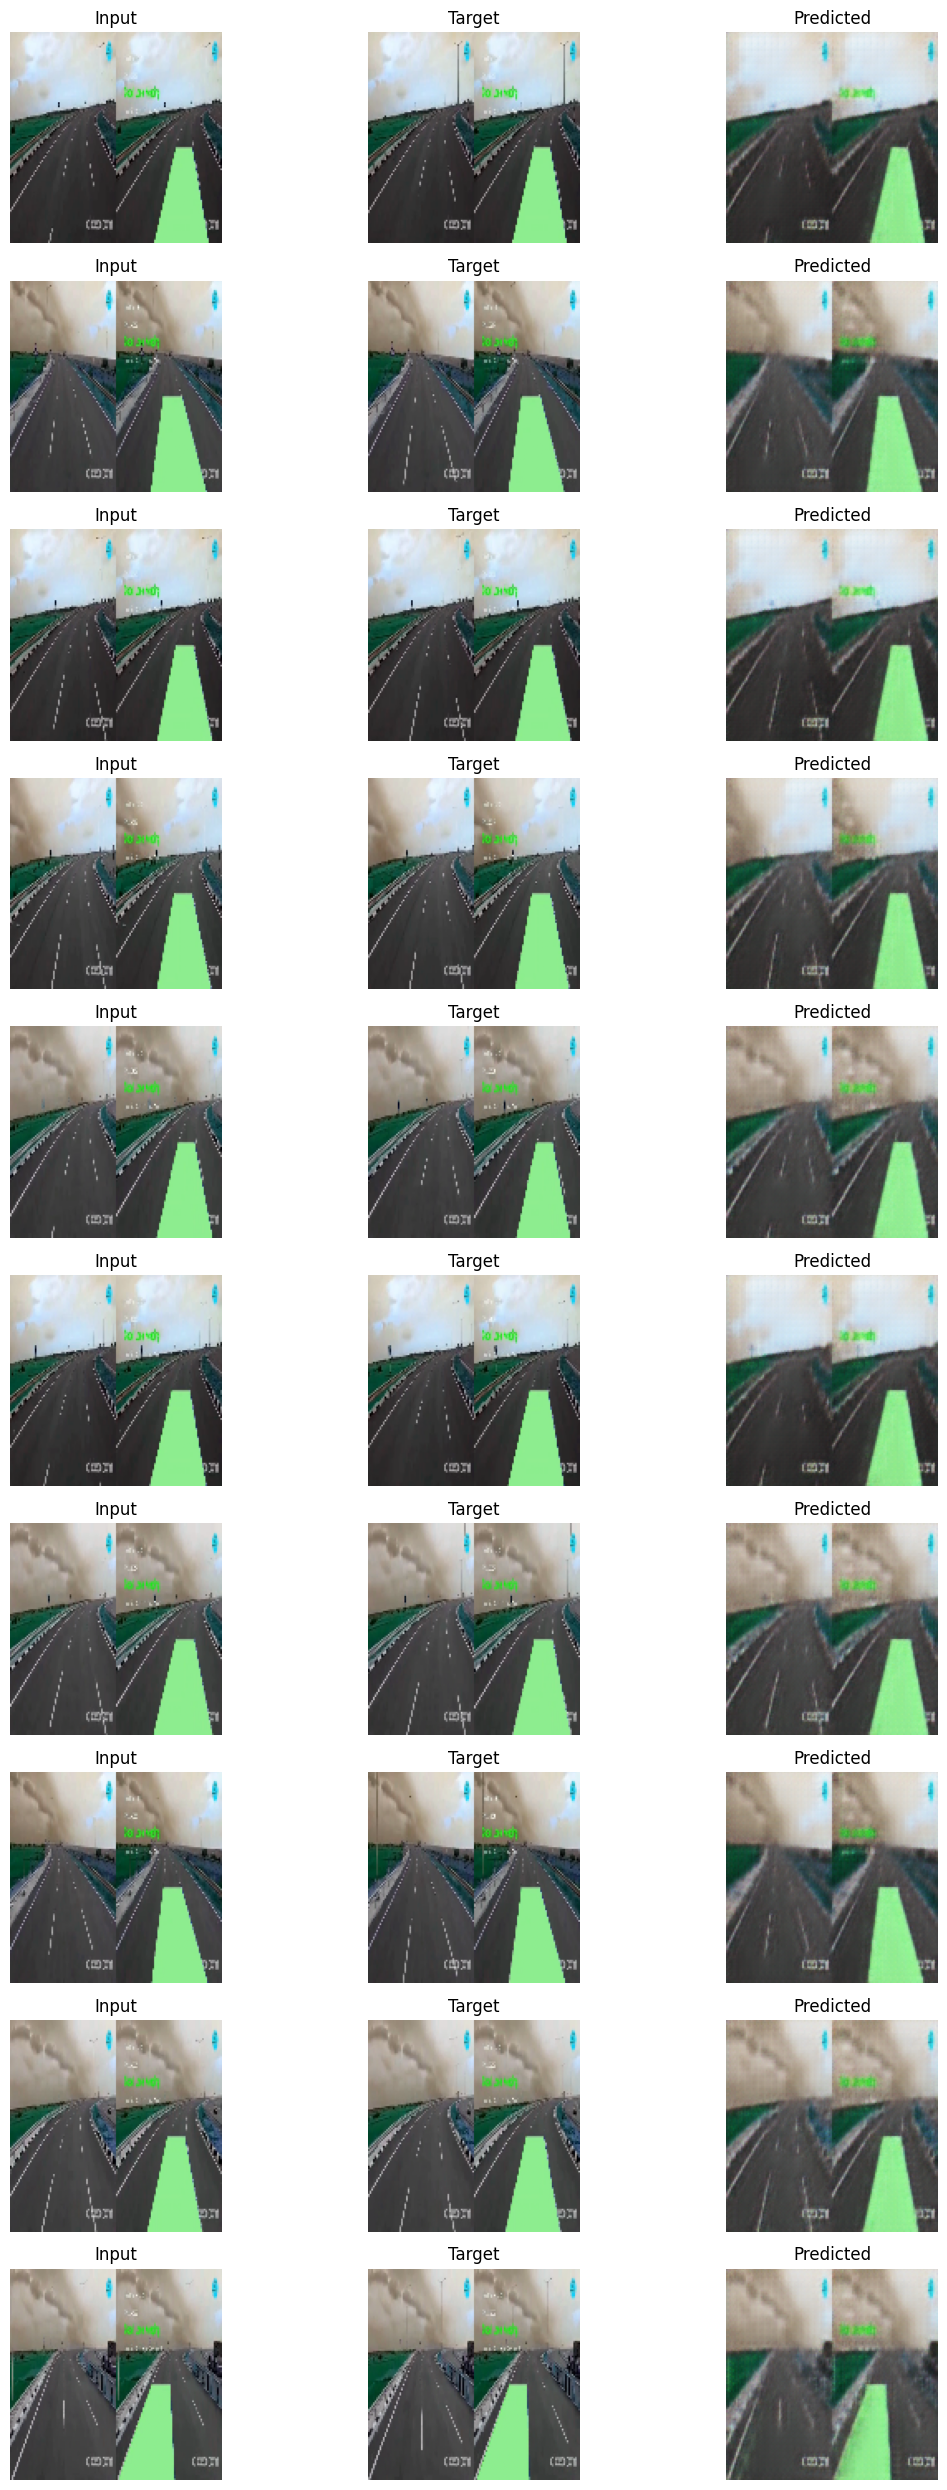

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 🔹 Number of random samples
num_samples = 10
indices = random.sample(range(len(x_val)), num_samples)

# 🔹 Select images and predict
selected_inputs = x_val[indices]
selected_targets = y_val[indices]
predictions = model.predict(selected_inputs)

# 🔹 Plot: Input - Target - Predicted per row
plt.figure(figsize=(12, num_samples * 2.5))

for i in range(num_samples):
    # Input
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(selected_inputs[i])
    plt.title("Input")
    plt.axis("off")

    # Target
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(selected_targets[i])
    plt.title("Target")
    plt.axis("off")

    # Prediction
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(predictions[i])
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()
